In [139]:
# Імпорт необхідних бібліотек
import os
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn as sk

# Імпорт бібліотек для моделювання
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from scipy.stats import f_oneway, kruskal
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR


print('Імпорт бібліотек завершено.')


Імпорт бібліотек завершено.


### Завантаження даних та первинний огляд

Завантажуємо датасет та переглядаємо перші рядки, інформацію та статистику числових ознак.

In [140]:
file_name = 'ikea.csv'
url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'

if not os.path.exists(file_name):
    response = requests.get(url)
    if response.status_code == 200:
        with open(file_name, 'wb') as file:
            file.write(response.content)

df = pd.read_csv(file_name)

df = pd.read_table(file_name,sep=',')

print('Перші 5 рядків даних:')
print(df.head().to_markdown())

print('\nІнформація про дані:')
print(df.info())

print('\nСтатистичний опис даних:')
print(df.describe().to_markdown())

Перші 5 рядків даних:
|    |   Unnamed: 0 |   item_id | name                  | category      |   price | old_price    | sellable_online   | link                                                                                               | other_colors   | short_description                               | designer             |   depth |   height |   width |
|---:|-------------:|----------:|:----------------------|:--------------|--------:|:-------------|:------------------|:---------------------------------------------------------------------------------------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|
|  0 |            0 |  90420332 | FREKVENS              | Bar furniture |     265 | No old price | True              | https://www.ikea.com/sa/en/p/frekvens-bar-table-in-outdoor-black-90420332/                         | No             | Bar table, in/outdoor,          51x51 cm        | Nicholai 

## Назви колонок
- tem_id — унікальний номер предмета

- name — назва предмета

- category — назва категорії

- price — ціна товару

- old_price — є чи немає старої ціни

- sellable_online — товар на інтернет-маркеті

- link — посилання на товар в маркеті

- other_colors — доступний чи немає інший колір предмета

- short_description — коротка інформація про предмет

- designer — ім'я дизайнера

- depth — глибина предмета

- height — висота предмета

- width — ширина елемента


**Опис статистичних даних**:

- Unnamed: 0. Порядковий номер запису. Значення варіюються від 0 до 3693. Має рівномірний розподіл.

- item_id. Унікальний ідентифікатор товару. Всі значення є позитивними. Мінімальне значення ≈ 58 487, максимальне ≈ 99 932 620. Значний розкид значень.

- price. Ціна товару. Діапазон: 3 – 9 585. Середня ціна ≈ 1078, медіана 544,7.
Велика стандартне відхілення (1374,65), що вказує на сильну варіативність.

- depth. Глибина товару (в сантиметрах). Від 1 до 257. Медіана = 47, середнє значення ≈ 54,4. Деякі значення можуть бути викидами.

- height. Висота товару.Від 1 до 700. Середнє значення ≈ 101,7, медіана 83. Велика дисперсія, можливі викиди.

- width. Ширина товару. Від 1 до 420. Медіана = 80, середнє ≈ 104,5. Можливі викиди.

### Перевірка на відсутні значення


In [141]:
print('Кількість відсутніх значень по кожній змінній:')
print(df.isnull().sum().to_markdown())

Кількість відсутніх значень по кожній змінній:
|                   |    0 |
|:------------------|-----:|
| Unnamed: 0        |    0 |
| item_id           |    0 |
| name              |    0 |
| category          |    0 |
| price             |    0 |
| old_price         |    0 |
| sellable_online   |    0 |
| link              |    0 |
| other_colors      |    0 |
| short_description |    0 |
| designer          |    0 |
| depth             | 1463 |
| height            |  988 |
| width             |  589 |


Виявлено, що у наборі даних є пропущені значення у колонках: depth, height, width.

### Видалимо дублікати

In [142]:
df=df.drop_duplicates(subset=['item_id'], keep='first').copy()

#перевірка
df.shape


(2962, 14)

### Відсіємо сутнісні дублікати
- знайдемо товари з однаковою назвою, у яких розміри відрізняються не більше ніж на 5%
- видалимо товари з одинаковим описом

In [143]:
# Сума розмірів для оцінки загального розміру
df['size'] = df[['depth', 'width', 'height']].sum(axis=1)

# Фільтруємо товари, де різниця в розмірах не більше ніж на 5% для однакових назв у межах однієї категорії
df_duplicates = df.groupby(['category', 'name']).filter(
    lambda x: (x['size'].min() != 0) and (x['size'].max() - x['size'].min()) / x['size'].min() <= 0.05
)

# Видаляємо дублікати за коротким описом і назвою в межах однієї категорії
df_filtered = df_duplicates.drop_duplicates(subset=['short_description', 'name', 'category'])



# Перевірка

df.shape

(2962, 15)

### Видалимо колонки, які не несуть в собі інформаціі

In [144]:
df = df.drop(['item_id', 'link', 'Unnamed: 0'], axis= 1)

#перевірка
df.shape

(2962, 12)

### Очистимо дизайнерів

In [145]:
#створимо функцію для очищення колонки 'designer'
def cleanDesigners(value, removeIKEA=False, emptyValue=np.nan):
    if not isinstance(value, str):
        return value

    if len(value)>0 and value[0].isdigit():
        return emptyValue

    designers = value.split("/")

    if removeIKEA:
        try:
            designers.remove("IKEA of Sweden")
        except:
            pass
    if len(designers) > 0:
        return '/'.join(sorted(designers))
    else:
        return emptyValue

In [146]:
df['designer_clean'] = df['designer'].apply(cleanDesigners, args= (False, "IKEA of Sweden"))
df['designer_clean'].head()

,designer_clean
0,Nicholai Wiig Hansen
1,Francis Cayouette
2,Francis Cayouette
3,Henrik Preutz
4,Marcus Arvonen


In [147]:
df['designer_clean'].value_counts()

,count
designer_clean,
IKEA of Sweden,785
Ehlén Johansson/IKEA of Sweden,138
Ehlén Johansson,136
Francis Cayouette,131
Ola Wihlborg,128
...,...
Gustav Carlberg/IKEA of Sweden/Johanna Asshoff,1
Chris Martin/IKEA of Sweden,1
J Karlsson/W Chong,1


### Очистимо по старим цінам

In [148]:
df['old_price'] = df['old_price'].replace('No old price', 'SR NaN')

list_price = []

for i in range(len(df)):
    old_price_value = df.iloc[i]['old_price']  # використовуємо iloc для звернення по індексу

    # Перевірка, чи є значення рядком
    if isinstance(old_price_value, str):
        price_parts = old_price_value.replace(',', '').replace('/', '.').strip().split(' ')
        item = 0 if price_parts[1] == 'NaN' else float(price_parts[1])
    else:
        # Якщо це число, просто використовуємо його
        item = old_price_value

    list_price.append(item)

df['old_price'] = list_price

print(df['old_price'].head().to_markdown())

|    |   old_price |
|---:|------------:|
|  0 |           0 |
|  1 |           0 |
|  2 |           0 |
|  3 |           0 |
|  4 |           0 |


In [149]:
print(df.columns)
df.info()
print(df.isnull().sum().to_markdown())

Index(['name', 'category', 'price', 'old_price', 'sellable_online',
       'other_colors', 'short_description', 'designer', 'depth', 'height',
       'width', 'size', 'designer_clean'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 2962 entries, 0 to 3692
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               2962 non-null   object 
 1   category           2962 non-null   object 
 2   price              2962 non-null   float64
 3   old_price          2962 non-null   float64
 4   sellable_online    2962 non-null   bool   
 5   other_colors       2962 non-null   object 
 6   short_description  2962 non-null   object 
 7   designer           2962 non-null   object 
 8   depth              1844 non-null   float64
 9   height             2236 non-null   float64
 10  width              2520 non-null   float64
 11  size               2962 non-null   float64
 12  designer_clea

**Висновок** нульові значення в трьох колонках

##Візуалізація

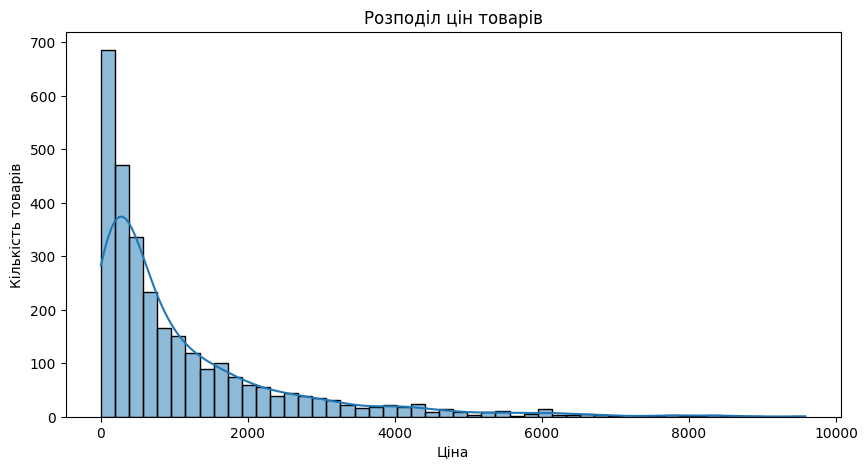

In [150]:
# Розподіл цін
plt.figure(figsize=(10, 5))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Розподіл цін товарів')
plt.xlabel('Ціна')
plt.ylabel('Кількість товарів')
plt.show()

**Висновок** більшість товарів мають низьку ціну. Розподіл є асиметричним і має довгий правий хвіст (доволі мало товарів мають дуже високу ціну). Розподіл э логнормальний. Гістограма демонструє, що переважна більшість товарів мають відносно низьку ціну, а товари з високою ціною зустрічаються значно рідше.

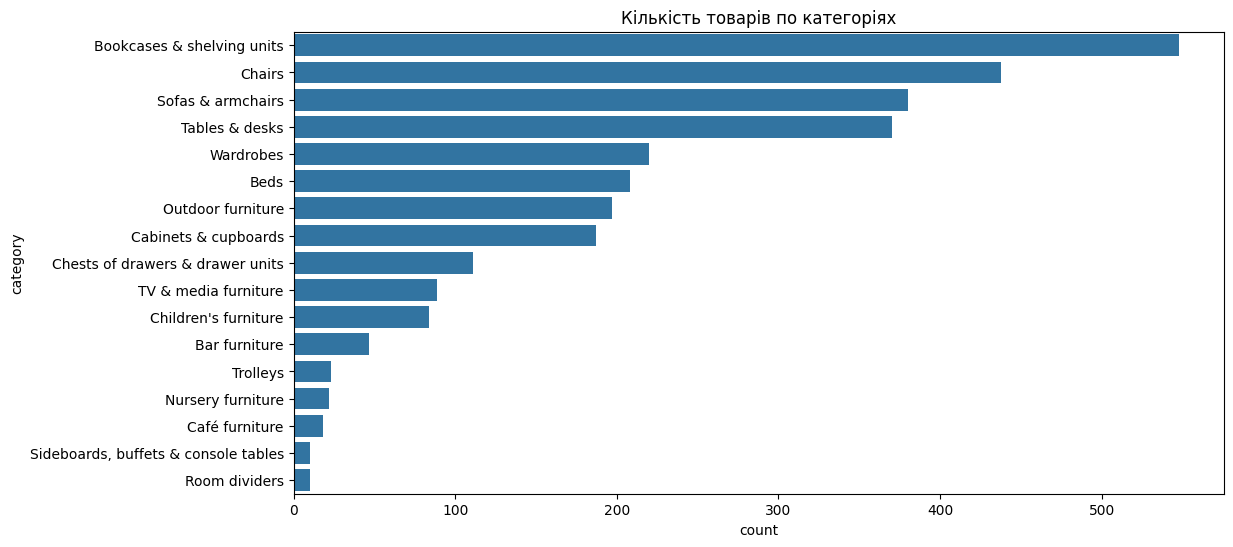

In [151]:
plt.figure(figsize=(12,6))
sns.countplot(y=df['category'], order=df['category'].value_counts().index)
plt.title("Кількість товарів по категоріях")
plt.show()


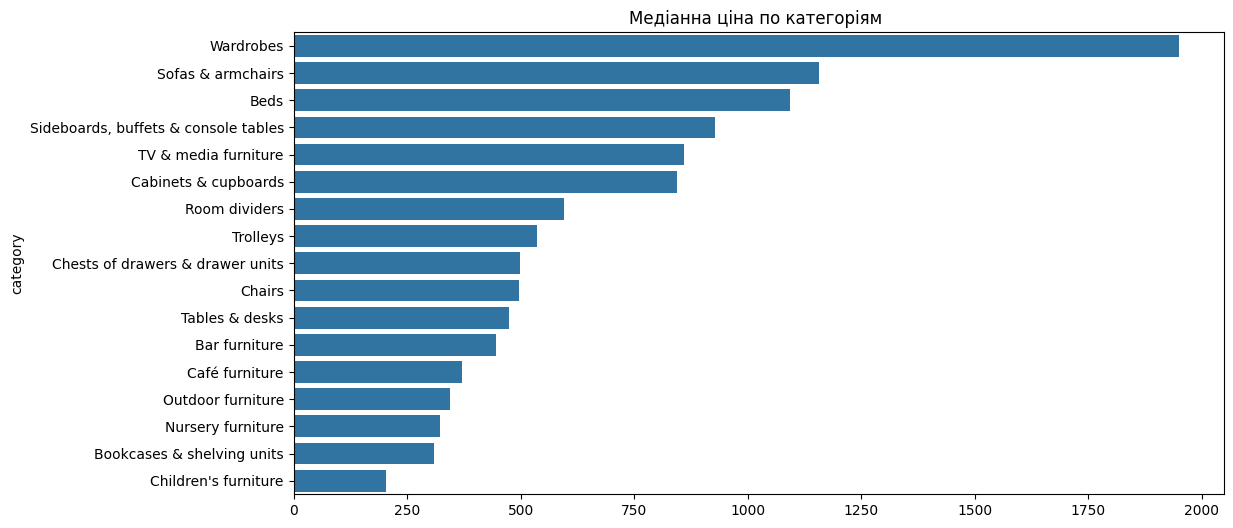

In [152]:
# Медіанна ціна по категоріям
category_median_price=df.groupby('category')['price'].median().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=category_median_price.values, y=category_median_price.index)
plt.title("Медіанна ціна по категоріям ")
plt.show()

**Висновок** бачимо, що найбільшу середню ціну мають категорії 'Wardrobes', 'Sofas & armchairs'

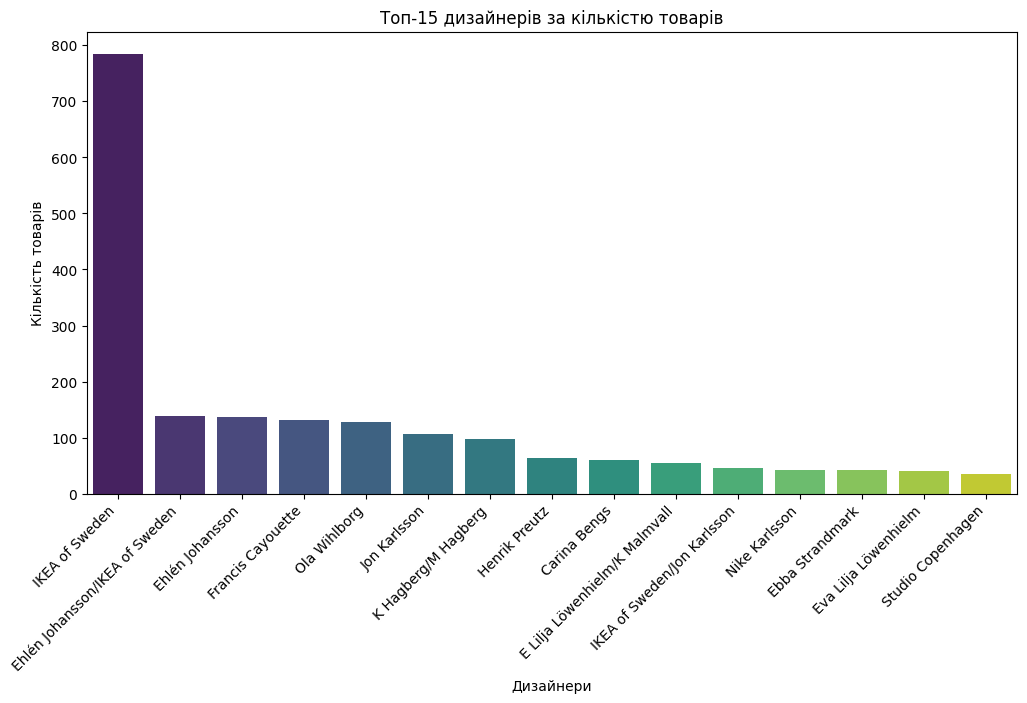

In [153]:
# Топ-15 дизайнерів
plt.figure(figsize=(12,6))
designer_counts = df['designer_clean'].value_counts().head(15)
sns.barplot(x=designer_counts.index, y=designer_counts.values, hue=designer_counts.index, palette='viridis', legend=False)
plt.title("Топ-15 дизайнерів за кількістю товарів")
plt.xlabel('Дизайнери')
plt.ylabel('Кількість товарів')
plt.xticks(rotation=45, ha='right')
plt.show()

In [154]:
designer_df_max=df.groupby('designer_clean')['price'].max()
print(designer_df_max)

designer_clean
A Fredriksson/H Preutz                                   75.0
A Fredriksson/HAY/J Hultqvist/W Chong                  2575.0
A Fredriksson/IKEA of Sweden/J Hultqvist/W Chong        675.0
A Fredriksson/J Hultqvist/Lisa Norinder/W Chong         889.0
A Fredriksson/J Hultqvist/Mikael Warnhammar/W Chong    2575.0
                                                        ...  
Tina Christensen                                       2585.0
Tom Dixon                                              3900.0
Tord Björklund                                         1195.0
Virgil Abloh                                            837.0
Wiebke Braasch                                          575.0
Name: price, Length: 199, dtype: float64


**Висновок** найдорожчий товар у дизайнера Tom Dixon

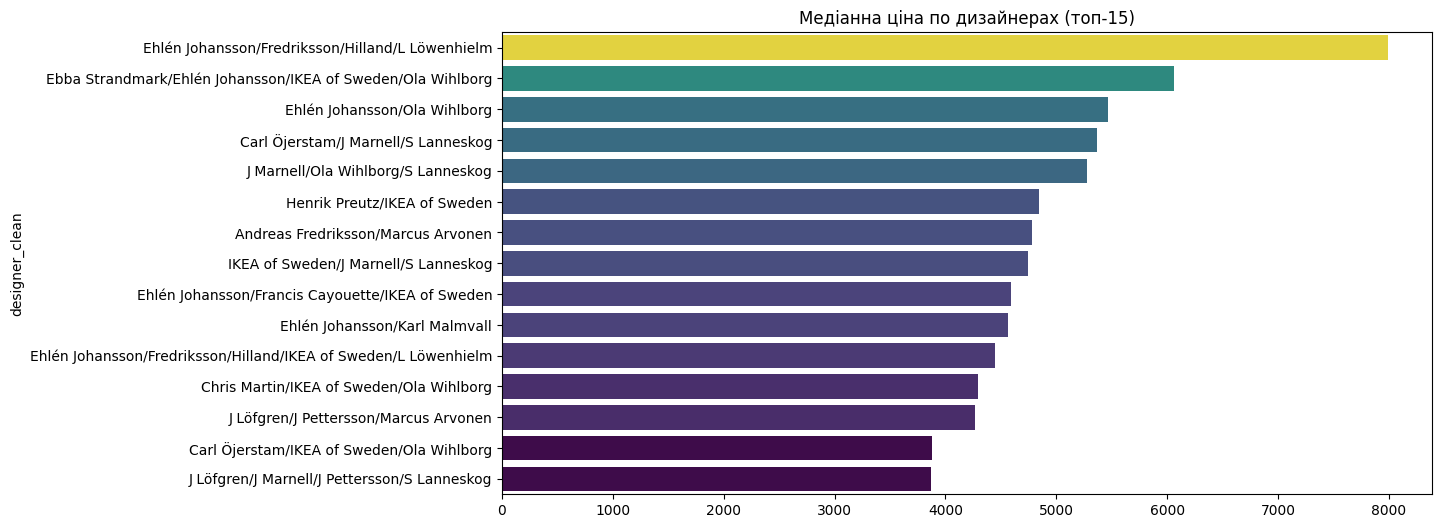

In [155]:
# Медіанна ціна по дизайнерах
designer_median_price = df.groupby('designer_clean')['price'].median().sort_values(ascending=False).head(15)
plt.figure(figsize=(12,6))
sns.barplot(x=designer_median_price.values, y=designer_median_price.index, hue=designer_median_price.values, palette='viridis', legend=False)
plt.title("Медіанна ціна по дизайнерах (топ-15)")
plt.show()


**Висновок** найбільші медіанні ціни зосереджені серед декількох дизайнерських груп, а IKEA відіграє важливу роль у цьому сегменті.

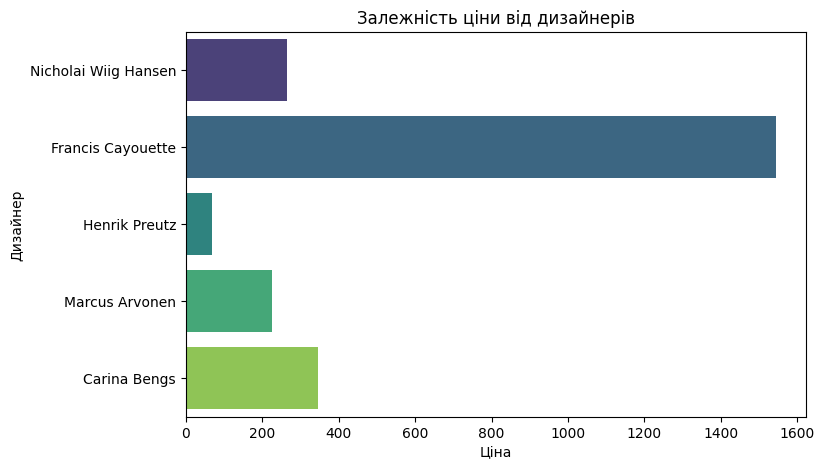

In [156]:
# Залежність ціни від дизайнерів
df1 = df[0:6]  # Візьмемо перших шість дизайнерів
plt.figure(figsize=(8, 5))
sns.barplot(x='price', y='designer_clean', data=df1, hue='designer_clean', palette='viridis', legend=False, errorbar=('ci', 0))
plt.title('Залежність ціни від дизайнерів')
plt.xlabel('Ціна')
plt.ylabel('Дизайнер')
plt.show()

**Висновок** Francis Cayouette має найдорожчі товари серед дизайнерів, представлених на графіку. Його середня ціна значно перевищує ціни інших дизайнерів, а також спостерігається велика варіативність цін.

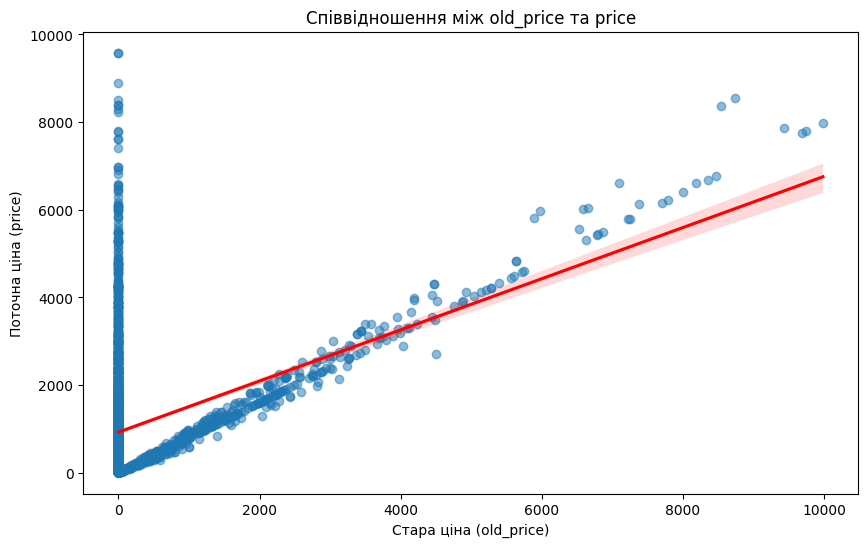

In [157]:
# Співвідношення старої ціни (old_price) та  поточної(price).
plt.figure(figsize=(10, 6))
sns.regplot(x='old_price', y='price', data=df, scatter_kws={'alpha':0.5}, line_kws={'color': 'red'})
plt.title('Співвідношення між old_price та price')
plt.xlabel('Стара ціна (old_price)')
plt.ylabel('Поточна ціна (price)')
plt.show()

**Висновок** ціни зазвичай зростають або залишаються приблизно на тому ж рівні, але є випадки різких змін, особливо в низькому ціновому сегменті.


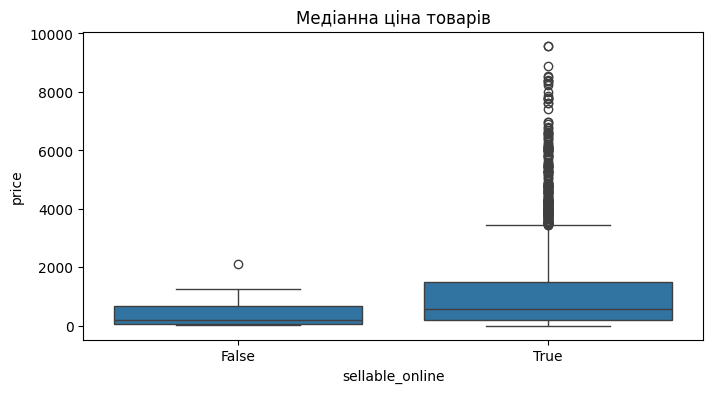

In [158]:
# Ціна товарів, що продаються / не продаються онлайн
plt.figure(figsize=(8,4))
sns.boxplot(x=df['sellable_online'], y=df['price'])
plt.title("Медіанна ціна товарів")
plt.show()

**Висновок** Товари, які продаються онлайн (sellable_online = True), мають значно більшу варіативність цін, у тому числі багато дорогих товарів із цінами понад 4000, а також значну кількість викидів. Медіанна ціна товарів, доступних онлайн, вища, ніж у товарів, які не продаються онлайн. Це може свідчити про те, що дорогі товари частіше представлені в онлайн-продажах

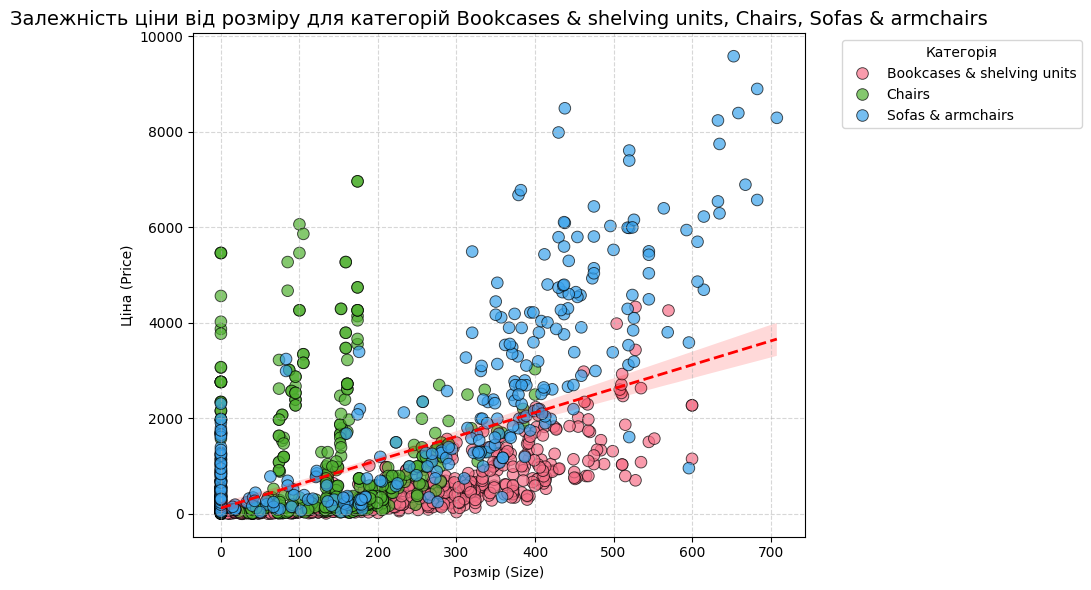

In [159]:
# Залежність ціни від розміру та категорії
top_categories = df['category'].value_counts().index[:3]
df_filtered = df[df['category'].isin(top_categories)]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='size', y='price', hue='category', data=df_filtered, palette='husl', s=70, alpha=0.7, edgecolor='black')
sns.regplot(x='size', y='price', data=df_filtered, scatter=False, color='red', line_kws={"linewidth": 2, "linestyle": "--"})
plt.title(f"Залежність ціни від розміру для категорій {', '.join(top_categories)}", fontsize=14)
plt.xlabel('Розмір (Size)')
plt.ylabel('Ціна (Price)')
plt.legend(title='Категорія', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


**Висновок**:
- Ціна в цілому зростає з розміром, але для різних категорій ця залежність варіюється.

- Sofas & armchairs мають найбільший розкид цін і високу середню вартість.

- Chairs мають як дешеві, так і дорогі екземпляри, незалежно від розміру.

- Bookcases & shelving units мають нижчі ціни порівняно з іншими категоріями.можемо стверджувати, що ціна товарів залежить від розміру.

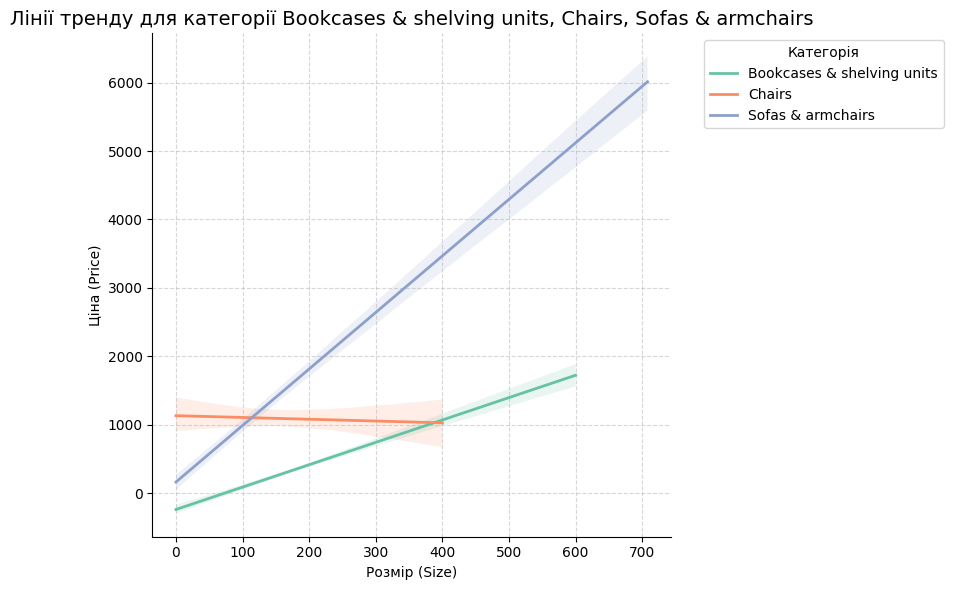

In [160]:
# Лінії тренду для кожної категорії
sns.lmplot(x='size', y='price', hue='category', data=df_filtered, palette='Set2', height=6, aspect=1.5, scatter=False, line_kws={'linewidth': 2}, legend=False)
plt.title(f"Лінії тренду для категорії {', '.join(top_categories)}", fontsize=14)
plt.xlabel('Розмір (Size)')
plt.ylabel('Ціна (Price)')
plt.grid(True, linestyle='--', alpha=0.5)

# Виносимо легенду за межі графіка
plt.legend(title='Категорія', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

plt.tight_layout()  # Щоб уникнути перекриття
plt.show()


**Висновок**: на графіку показано лінійною регресією з трендовими лініями. Бачимо в яких категоріях найбільша залежність ціни від розміру.


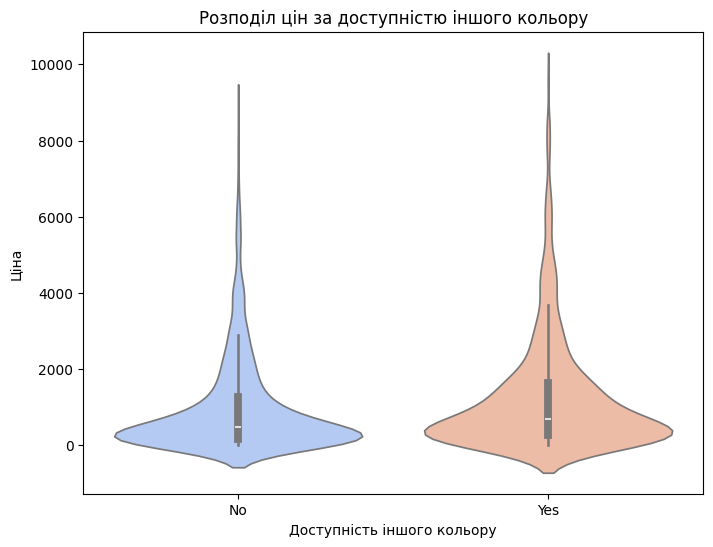

In [161]:
# Розподіл цін за доступністю іншого кольору
plt.figure(figsize=(8, 6))
sns.violinplot(x='other_colors', y='price', hue='other_colors', data=df, palette='coolwarm', legend=False)
plt.title('Розподіл цін за доступністю іншого кольору')
plt.xlabel('Доступність іншого кольору')
plt.ylabel('Ціна')
plt.show()

**Висновок**: доступність іншого кольору може впливати на розподіл цін. Товари з доступним іншим кольором можуть мати більшу варіативність у цінах.

In [162]:
#Створимо нову колонку для наявності додаткових кольорів
df['other_colors_1'] = df['other_colors'].map(dict(Yes=1, No=0))
df = df.reset_index()
print(df.head().to_markdown())

|    |   index | name                  | category      |   price |   old_price | sellable_online   | other_colors   | short_description                               | designer             |   depth |   height |   width |   size | designer_clean       |   other_colors_1 |
|---:|--------:|:----------------------|:--------------|--------:|------------:|:------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|-------:|:---------------------|-----------------:|
|  0 |       0 | FREKVENS              | Bar furniture |     265 |           0 | True              | No             | Bar table, in/outdoor,          51x51 cm        | Nicholai Wiig Hansen |     nan |       99 |      51 |    150 | Nicholai Wiig Hansen |                0 |
|  1 |       1 | NORDVIKEN             | Bar furniture |     995 |           0 | False             | No             | Bar table,          140x80 cm                   | Francis Cayou

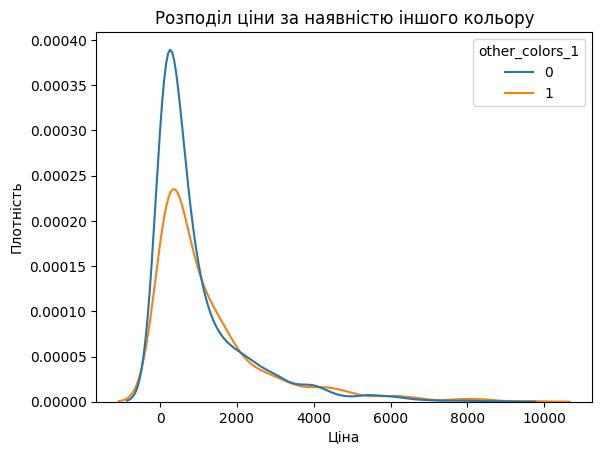

In [163]:
sns.kdeplot(data=df, x='price', hue='other_colors_1')
plt.title('Розподіл ціни за наявністю іншого кольору')
plt.xlabel('Ціна')
plt.ylabel('Плотність')
plt.show()

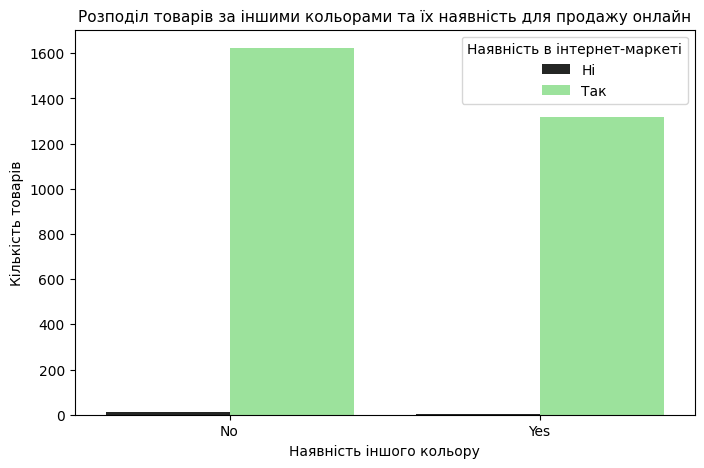

In [164]:
# Розподіл товарів за іншими кольорами та їх наявність для продажу онлайн
plt.figure(figsize=(8, 5))
sns.countplot(x='other_colors', hue='sellable_online', data=df, palette='dark:lightgreen')
plt.title('Розподіл товарів за іншими кольорами та їх наявність для продажу онлайн', fontsize=11)
plt.xlabel('Наявність іншого кольору')
plt.ylabel('Кількість товарів')
plt.legend(title='Наявність в інтернет-маркеті', labels=['Ні', 'Так'],bbox_to_anchor=(1, 1))
plt.show()

In [165]:
# Продажі онлайн
df['sellable_online'].value_counts() #19 товарів не продаються онлайн

,count
sellable_online,
True,2943
False,19


### Pairplot для аналізу взаємозв’язків

Будуємо pairplot для аналізу взаємозв’язків між основними числовими ознаками (за нявністю інших кольорів).

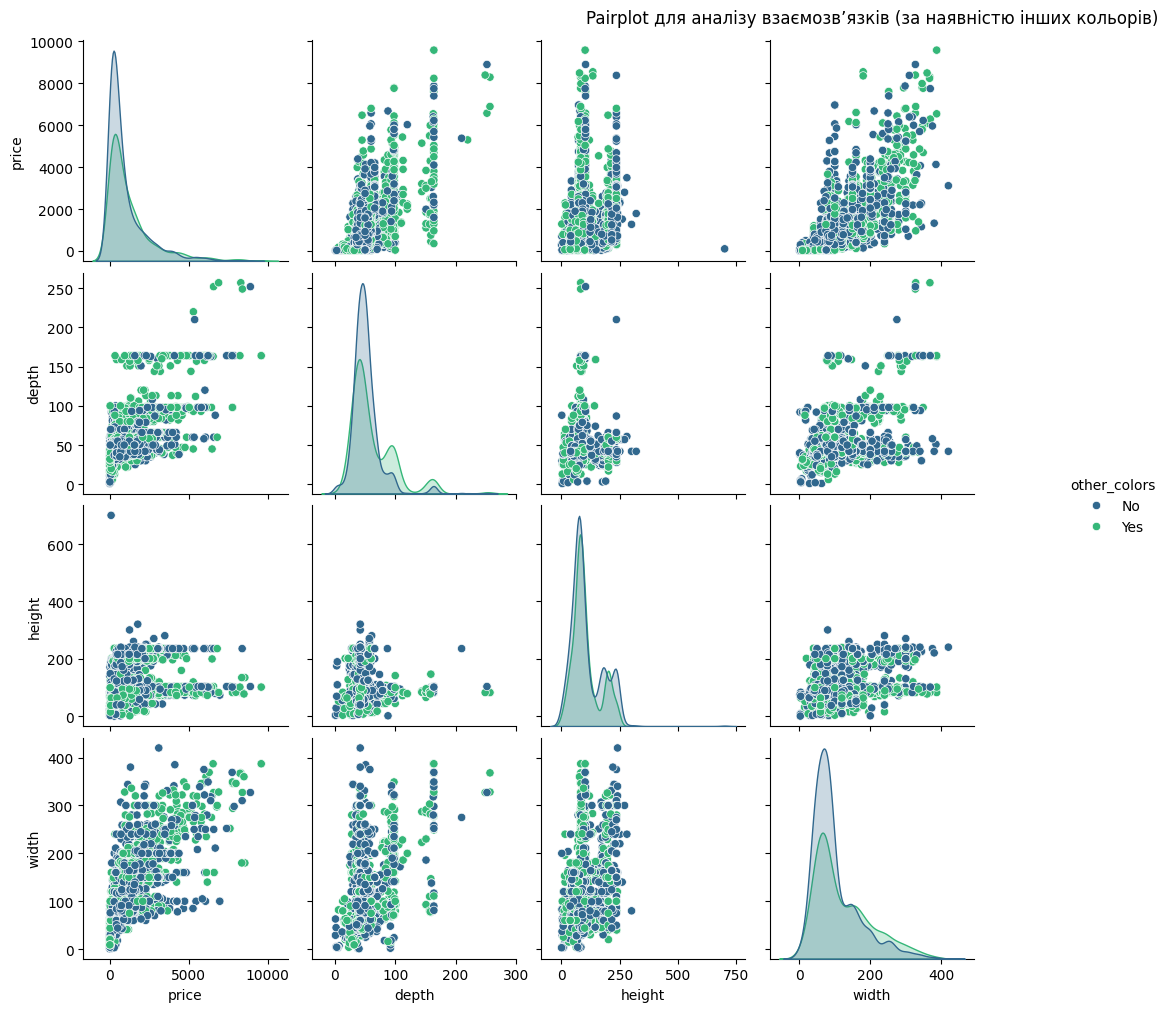

In [166]:
sns.pairplot(df[['price', 'depth', 'height', 'width', 'other_colors','category']], hue='other_colors', palette='viridis')
plt.title("Pairplot для аналізу взаємозв’язків (за наявністю інших кольорів)", y=4.2)
plt.show()

**Висновок** на ціноутворення можуть впливати ширина,висота,глибина

### Кореляційна матриця

Побудова теплової карти для візуалізації кореляцій між числовими ознаками.  Використовуємо лише числові колонки.

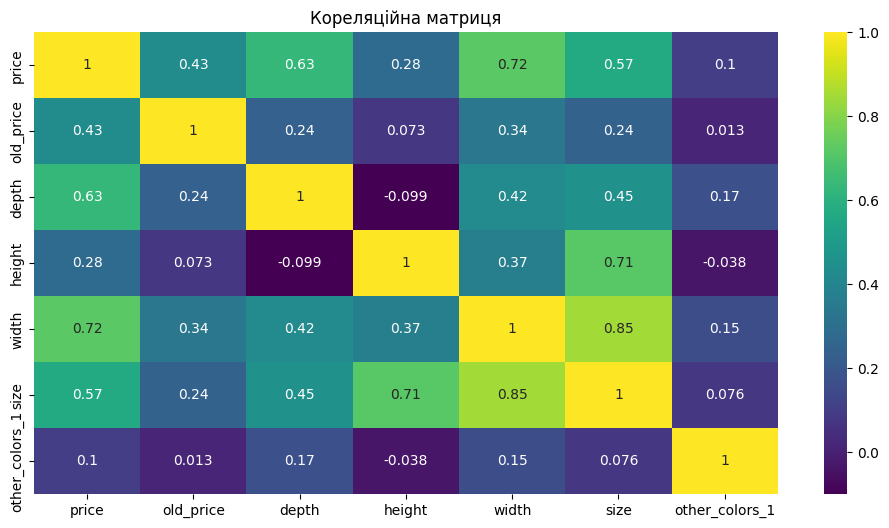

In [167]:
plt.figure(figsize=(12, 6))

numeric_cols = df.select_dtypes(include=[np.number]).drop(columns=['index'], errors='ignore')

sns.heatmap(numeric_cols.corr(), annot=True, cmap='viridis')

plt.title('Кореляційна матриця')
plt.show()

**Висновок** : теплова карта свідчить про взаємозв'язок `price` i `width` , `depth` , `heigh` , `size`

### Зробимо логарифмування
(для підготовки даних до аналізу, щоб зробити їх більш нормальними, лінійними та зменшує вплив викидів)

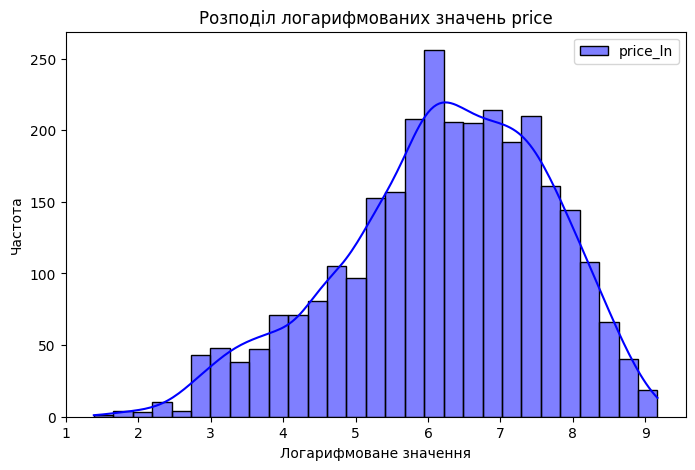

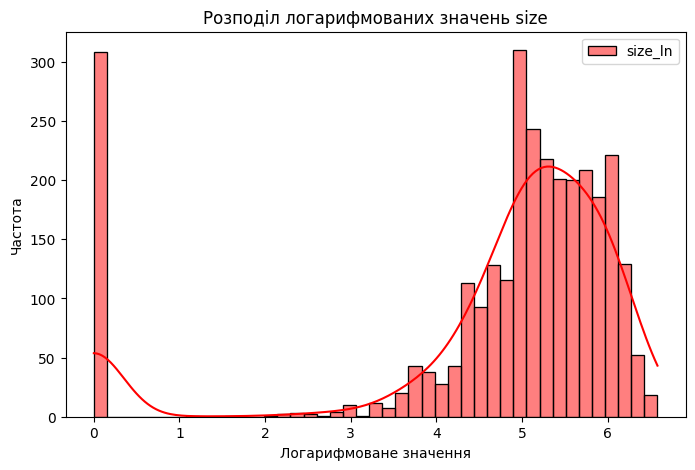

In [168]:
# Логарифмування ціни
df['price_ln'] = np.log(df['price'] + 1)
# Логарифмування розміру
df['size_ln'] = np.log(df['size'] + 1)


plt.figure(figsize=(8, 5))
sns.histplot(df['price_ln'], kde=True, color="blue", alpha=0.5, label="price_ln")
plt.title("Розподіл логарифмованих значень price")
plt.xlabel("Логарифмоване значення")
plt.ylabel("Частота")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['size_ln'], kde=True, color="red", alpha=0.5, label="size_ln")
plt.title("Розподіл логарифмованих значень size")
plt.xlabel("Логарифмоване значення")
plt.ylabel("Частота")
plt.legend()
plt.show()




**Висновок** на графіку помітно що логарифмування ціни вирівняло розподіл – замість початкового сильно скошеного розподілу (з довгим правим хвостом) ми отримали більш симетричний розподіл , логарифмування розміру також.

#Розглянимо гіпотези впливу на ціну.

###Гіпотеза 1
-H₀: ціна не залежить від кольору

-H₁: ціна залежить від кольору



In [169]:
# Фільтруємо товари з різними кольорами
colors_yes = df[df['other_colors'] == 'Yes']['price']
colors_no = df[df['other_colors'] == 'No']['price']

# Обчислюємо середні ціни
mean_yes = colors_yes.mean()
mean_no = colors_no.mean()

print(f"Середня ціна товарів з іншими кольорами: {mean_yes:.2f}")
print(f"Середня ціна товарів без інших кольорів: {mean_no:.2f}")

# Перевіряємо, чи є різниця значущою (t-тест)
t_stat, p_value = stats.ttest_ind(colors_yes, colors_no, equal_var=False)
print(f"T-статистика: {t_stat:.4f}, p-значення: {p_value:.4f}")

# Виконуємо ANOVA тест
anova_stat, anova_p = stats.f_oneway(colors_yes, colors_no)
print(f"ANOVA F-статистика: {anova_stat:.4f}, p-значення: {anova_p:.4f}")

# Інтерпретація
if p_value < 0.05:
    print("Різниця в цінах статистично значуща (t-тест).")
else:
    print("Немає статистично значущої різниці в цінах (t-тест).")

if anova_p < 0.05:
    print("Різниця в цінах статистично значуща (ANOVA).")
else:
    print("Немає статистично значущої різниці в цінах (ANOVA).")


Середня ціна товарів з іншими кольорами: 1265.85
Середня ціна товарів без інших кольорів: 981.54
T-статистика: 5.4472, p-значення: 0.0000
ANOVA F-статистика: 30.7859, p-значення: 0.0000
Різниця в цінах статистично значуща (t-тест).
Різниця в цінах статистично значуща (ANOVA).


# Висновок:
Аналіз показав, що середня ціна товарів, представлених у кількох кольорах (1223.86), значно вища, ніж у товарів без альтернативних кольорових варіантів (829.90).

- Статистичний тест (t-тест):
##### T = 6.7429 (значення T (t-статистика) показує, наскільки велика різниця між середніми у порівнянні зі стандартною помилкою. Чим вище значення T, тим більша різниця між групами і тим менша ймовірність, що ця різниця випадкова. Значення T = 6.7429 є доволі великим, що може вказувати на суттєву різницю між групами)
#####і p-значення = 0.000, що означає, що різниця між групами статистично значуща (p < 0.05).

- ANOVA тест:
##### дав значення F = 45.7563 (F-статистика показує співвідношення між міжгруповою дисперсією (відмінності між групами) і внутрішньогруповою дисперсією (відмінності всередині груп). Чим вище значення F, тим більші відмінності між групами порівняно з варіацією всередині кожної групи. F = 45.7563 – дуже велике значення, що вказує на суттєву різницю між середніми значеннями груп.
##### p-значення = 0.000, що означає, що різниця між групами статистично значуща (p < 0.05).

Це підтверджує гіпотезу про те, що товари з різними кольоровими варіантами в середньому дорожчі.

###Гіпотеза 2
-H₀: ціна не залежить від розміру

-H₁: ціна залежить від розміру



In [170]:
# Кореляція Спірмена
spearman_corr, spearman_p = stats.spearmanr(df['size_ln'], df['price_ln'])
print(f"Spearman correlation: {spearman_corr:.4f}, P-value: {spearman_p:.5f}")

# Регресія для оцінки впливу розміру на логарифм ціни
slope, intercept, r_value, p_value, std_err = stats.linregress(df['size_ln'], df['price_ln'])
print(f"Linear regression: Slope={slope:.4f}, Intercept={intercept:.4f}, R²={r_value**2:.4f}, P-value={p_value:.5f}")

Spearman correlation: 0.5875, P-value: 0.00000
Linear regression: Slope=0.2822, Intercept=4.8913, R²=0.1174, P-value=0.00000


- Кореляція Спірмена:
##### Результат кореляції Спірмена 0.5937 (Кореляція Спірмена (Spearman's rank correlation coefficient) – це непараметричний метод, який оцінює монотонний зв’язок між двома змінними. Вона використовується, коли: Дані можуть бути не нормальними або містити викиди. Зв’язок між змінними не обов’язково лінійний, але може бути монотонним (збільшується або зменшується). Значення коефіцієнта Спірмена (ρ) знаходиться в діапазоні від -1 до 1: ρ ≈ 1 – сильна пряма (позитивна) кореляція; ρ ≈ -1 – сильна зворотна (негативна) кореляція; ρ ≈ 0 – відсутність кореляції), це означає помірно сильний позитивний зв’язок між двома змінними. вказує на помірно сильну позитивну кореляцію між розміром та логарифмованою ціною.
##### P-значення 0.00000 (менше 0.05), ми відкидаємо нулеву гіпотезу (що ціна не залежить від розміру) і приймаємо альтернативну гіпотезу (що ціна залежить від розміру).


- Лінійна регресія:

##### Показник R2 =0.1207 (R² показує, наскільки добре модель пояснює варіацію залежної змінної). Значення 0.1207 означає, що лише 12.07% варіації у залежній змінній пояснюється незалежною змінною. Це низьке значення, що вказує на слабку пояснювальну здатність моделі. Ймовірно, є інші фактори, які впливають на залежну змінну.
##### P-значення 0.00000 вказує на статистичну значущість результатів лінійної регресії.

Є статистично значуща позитивна залежність між розміром і ціною (логарифмована ціна).
Розмір товару впливає на ціну, хоча модель лінійної регресії пояснює лише частину варіації цін (приблизно 12,07%). Це може вказувати на наявність інших факторів, які також впливають на ціну.

### Гіпотеза 3

-H₀: ціна не залежить від довжини назви товару

-H₁: ціна залежить від довжини назви товару

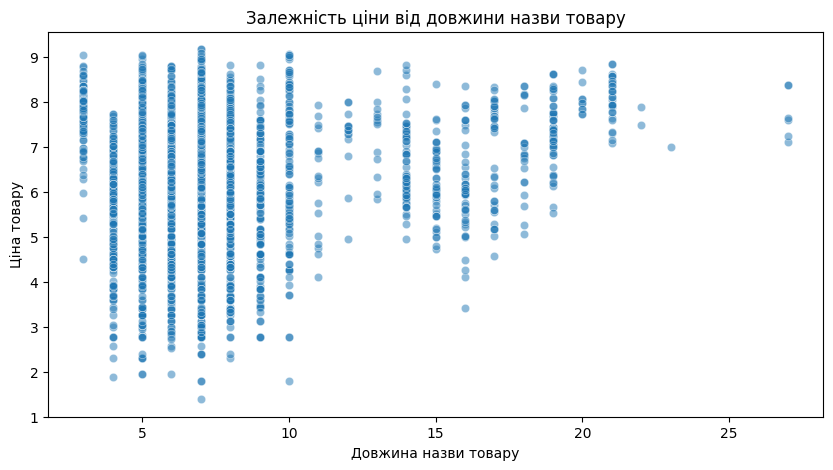

Коэффициент корреляции Пірсона: 0.1468
Різниця між групами не є статистично значущою.

Bootstrap Test для цін (price_ln):
P-value: 0.499
Різниця між групами не є статистично значущою.


In [171]:
# Додаємо нову колонку з довжиною назви товару
df["title_length"] = df["name"].apply(lambda x: len(str(x)))

# График залежності ціни від довжини назви
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df, x="title_length", y="price_ln", alpha=0.5)
plt.xlabel("Довжина назви товару")
plt.ylabel("Ціна товару")
plt.title("Залежність ціни від довжини назви товару")
plt.show()

# Коефіцієнт кореляції Пірсона
correlation = df["title_length"].corr(df["price_ln"])
print(f"Коэффициент корреляции Пірсона: {correlation:.4f}")

# Інтерпретація
if correlation  < 0.05:
    print("Існує статистично значуща різниця між групами.")
else:
    print("Різниця між групами не є статистично значущою.")


### Bootstrap Test
def bootstrap_test(x, y, n_bootstraps=10000):
    diffs = []
    for _ in range(n_bootstraps):
        x_samples = np.random.choice(x, size=len(x), replace=True)
        y_samples = np.random.choice(y, size=len(y), replace=True)
        diffs.append(np.abs(np.mean(x_samples) - np.mean(y_samples)))

    p_value = np.mean(np.array(diffs) >= np.abs(np.mean(x) - np.mean(y)))
    print(f"P-value: {p_value:.3f}")
    return p_value

# Розділяємо дані на дві групи: короткі назви та довгі назви
median_title_length = df["title_length"].median()  # Медіанна довжина назви
short_title_df = df[df["title_length"] <= median_title_length]
long_title_df = df[df["title_length"] > median_title_length]

# Виконуємо Bootstrap Test для порівняння цін між групами
print("\nBootstrap Test для цін (price_ln):")
p_value = bootstrap_test(short_title_df["price_ln"], long_title_df["price_ln"])

# Інтерпретація результату Bootstrap Test
if p_value < 0.05:
    print("Існує статистично значуща різниця між групами.")
else:
    print("Різниця між групами не є статистично значущою.")

Кореляція Пірсона:
##### r = 0.1088 (це показник лінійного зв’язку між двома змінними. Вона варіюється від -1 до 1: r ≈ 1 – сильний позитивний зв’язок (значення обох змінних збільшуються разом); r ≈ -1 – сильний негативний зв’язок (одна змінна збільшується, а інша зменшується;r ≈ 0 – зв’язок відсутній або дуже слабкий.)Значення 0.1088 близьке до нуля, що означає дуже слабкий позитивний зв’язок між змінними. Це означає, що зміна однієї змінної майже не впливає на зміну іншої.

##### Оскільки p-value = 0.495 (більше 0.05), ми не можемо сказати, що різниця між групами значуща. Це означає, що ціни (у логарифмічному масштабі) у двох групах не мають суттєвих відмінностей.

### Гіпотеза 4

-H₀: ціна не залежить від заокруглення ціни

-H₁: ціна залежить від заокруглення ціни

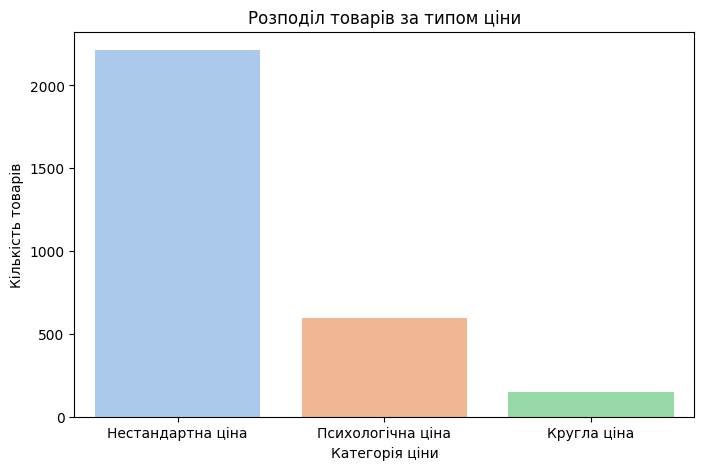

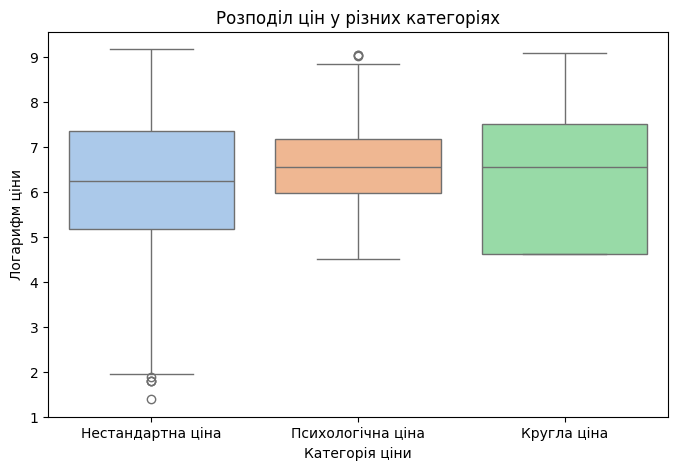

ANOVA p-value: 0.0000
Kruskal-Wallis p-value: 0.0000
ANOVA: Відмінності між групами статистично значущі!
Kruskal-Wallis: Відмінності між групами статистично значущі!


In [172]:
# Функція для класифікації цін
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal

# Функція для класифікації цін
def categorize_price(price):
    price_str = str(round(price))
    if price_str.endswith(("99", "95", "90")):
        return "Психологічна ціна"
    elif price % 100 == 0:
        return "Кругла ціна"
    else:
        return "Нестандартна ціна"

# Створення нової колонки
df["price_category"] = df["price"].apply(categorize_price)

# Візуалізація розподілу товарів за типом ціни
plt.figure(figsize=(8, 5))
sns.countplot(x=df["price_category"], hue="price_category", data=df, palette="pastel", legend=False)
plt.xlabel("Категорія ціни")
plt.ylabel("Кількість товарів")
plt.title("Розподіл товарів за типом ціни")
plt.show()

# Порівняння розподілу цін у категоріях за допомогою boxplot
plt.figure(figsize=(8, 5))
sns.boxplot(x="price_category", y="price_ln", data=df, hue="price_category", palette="pastel", legend=False)
plt.xlabel("Категорія ціни")
plt.ylabel("Логарифм ціни")
plt.title("Розподіл цін у різних категоріях")
plt.show()

# Групуємо дані по категоріях для тестів
groups = [df[df["price_category"] == cat]["price_ln"].dropna() for cat in df["price_category"].unique()]

# ANOVA тест
stat_anova, p_anova = f_oneway(*groups)
print(f"ANOVA p-value: {p_anova:.4f}")

# Kruskal-Wallis тест (якщо дані не нормально розподілені)
stat_kruskal, p_kruskal = kruskal(*groups)
print(f"Kruskal-Wallis p-value: {p_kruskal:.4f}")

# Інтерпретація результатів
if p_anova < 0.05:
    print("ANOVA: Відмінності між групами статистично значущі!")
else:
    print("ANOVA: Відмінності між групами незначні.")

if p_kruskal < 0.05:
    print("Kruskal-Wallis: Відмінності між групами статистично значущі!")
else:
    print("Kruskal-Wallis: Відмінності між групами незначні.")

- ANOVA: p-value = 0.0000, що є значно меншим за стандартний рівень значущості 0.05. Це свідчить про те, що між групами існують статистично значущі відмінності. Таким чином, ми можемо відхилити нульову гіпотезу, що стверджує про відсутність відмінностей між групами.

- Kruskal-Wallis: p-value = 0.0000, що також є значно меншим за рівень значущості 0.05. Це свідчить про те, що відмінності між групами є статистично значущими, навіть якщо дані не розподіляються нормально, оскільки тест Крускала-Валіса є непараметричним.

Отже, обидва тести (ANOVA та Kruskal-Wallis) вказують на статистично значущі відмінності між групами.

# Машине навчання


###Заповнемо пусті значення (фактори габаритів згрупуємо за категорією та заповнимо відсутні значення медіанними значеннями)

In [173]:
# Заповнюємо пропуски для 'depth', 'height' та 'width' за медіанними значеннями по категоріях
median_d = df.groupby(['category'])['depth'].median()
median_h = df.groupby(['category'])['height'].median()
median_w = df.groupby(['category'])['width'].median()

median_price = df.groupby(['category'])['price'].median()
median_dsgn =  df.groupby(['designer_clean'])['price'].median()

df = df.set_index(['category'])
df['depth_1'] = df['depth'].fillna(median_d)
df['height_1'] = df['height'].fillna(median_h)
df['width_1'] = df['width'].fillna(median_w)
df['category_median_price'] = median_price

df = df.reset_index()

df = df.set_index(['designer_clean'])
df['designer_median_price'] = median_dsgn
df = df.reset_index()
print(df.head().to_markdown())

|    | designer_clean       | category      |   index | name                  |   price |   old_price | sellable_online   | other_colors   | short_description                               | designer             |   depth |   height |   width |   size |   other_colors_1 |   price_ln |   size_ln |   title_length | price_category    |   depth_1 |   height_1 |   width_1 |   category_median_price |   designer_median_price |
|---:|:---------------------|:--------------|--------:|:----------------------|--------:|------------:|:------------------|:---------------|:------------------------------------------------|:---------------------|--------:|---------:|--------:|-------:|-----------------:|-----------:|----------:|---------------:|:------------------|----------:|-----------:|----------:|------------------------:|------------------------:|
|  0 | Nicholai Wiig Hansen | Bar furniture |       0 | FREKVENS              |     265 |           0 | True              | No             | Bar table, 

In [174]:
print(df.isnull().sum())

designer_clean              0
category                    0
index                       0
name                        0
price                       0
old_price                   0
sellable_online             0
other_colors                0
short_description           0
designer                    0
depth                    1118
height                    726
width                     442
size                        0
other_colors_1              0
price_ln                    0
size_ln                     0
title_length                0
price_category              0
depth_1                     0
height_1                    0
width_1                     0
category_median_price       0
designer_median_price       0
dtype: int64


## Прогнозування ціни

**Вхідні ознаки:** `category`, `other_colors`, `designer_count`, `depth`, `height`, `width`
       
**Цільова змінна:** `price`

Будуть застосовані наступні моделі:

- **KNeighborsRegressor (KNN Regressor)**(для кожного нового спостереження модель шукає найближчі точки (сусіди) з навчального набору і використовує їх значення для прогнозування)
- **DecisionTreeRegressor** (алгоритм будує дерево рішень, де кожен вузол представляє ознаку, а гілки — можливі варіанти для цієї ознаки. Рішення приймається на основі найкращого розбиття даних.)
-**Gradient Boosting Regressor** (кожен новий деревоподібний класифікатор або регресор навчається на помилках попереднього дерева. Моделі додаються поступово, і кожна нова модель виправляє помилки попередніх.)
- **RandomForestRegressor**(Створення багатьох дерев рішень на випадкових підмножинах даних і комбінування їх результатів для отримання точного прогнозу.)
- **LassoCV**( модель, що є варіантом Lasso Regression (Least Absolute Shrinkage and Selection Operator), яка застосовує метод регуляризації L1 для зменшення коефіцієнтів регресії та вибору важливих ознак. LassoCV використовує крос-валідацію для вибору найкращого параметра регуляризації (α), що оптимізує модель.)
- **RidgeCV**(варіант Ridge Regression (регресія з L2 регуляризацією), який використовує крос-валідацію для автоматичного вибору оптимального параметра регуляризації α.)
-**SVR** (Support Vector Regression (Регресія за допомогою опорних векторів)
SVR є методом регресії, який використовує концепцію опорних векторів з Support Vector Machine (SVM) для побудови моделей, що можуть прогнозувати без лінійних обмежень. SVR застосовується, коли необхідно побудувати регресійну модель для даних, що можуть бути нелінійними або містити складні залежності між ознаками.)


Для кожної моделі проводиться крос-валідація (метрика R², MAE, RMSE) та підбір гіперпараметрів за допомогою GridSearchCV.


In [175]:
#створимо функцію, для тестування регресійних моделей на основі метрик ( R², MAE, RMSE).

def getBestRegressor(X, Y):
    X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

    models = [
        ('LinearRegression', sk.linear_model.LinearRegression()),
        ('LassoCV', sk.linear_model.LassoCV()),
        ('RidgeCV', sk.linear_model.RidgeCV()),
        ('SVR', sk.svm.SVR(kernel='linear')),
        ('KNeighborsRegressor', sk.neighbors.KNeighborsRegressor(n_neighbors=16)),
        ('DecisionTreeRegressor', sk.tree.DecisionTreeRegressor(max_depth=10, random_state=42)),
        ('RandomForestRegressor', RandomForestRegressor(random_state=42)),
        ('GradientBoostingRegressor', GradientBoostingRegressor())
    ]

    TestModels = pd.DataFrame()
    res = {}
    tmp = {}

    for model_name, model in models:  # Розпаковуємо кортеж у model_name та model
        model.fit(X_train, Y_train)  # Тепер працюємо без помилок
        tmp['Model'] = model_name
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, Y_test))
        tmp['MAE'] = '{:.5f}'.format(sk.metrics.mean_absolute_error(model.predict(X_test), Y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(sk.metrics.mean_squared_error(model.predict(X_test), Y_test)))

        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])

    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res


    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = Y_train
    res['X_test'] = X_test
    res['Y_test'] = Y_test
    return res

In [176]:
X1 = df[['depth_1', 'width_1', 'height_1', 'category_median_price', 'designer_median_price', 'other_colors_1']]
Y1 = df['price']

test1 = getBestRegressor(X1, Y1)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.81429,346.71953,591.42637
GradientBoostingRegressor,0.78445,398.70825,637.16866
DecisionTreeRegressor,0.73404,422.64848,707.76814
KNeighborsRegressor,0.67845,477.50886,778.22677
SVR,0.66697,503.84661,792.00331
LinearRegression,0.65885,541.31204,801.59311
RidgeCV,0.65878,541.30596,801.67756
LassoCV,0.65791,536.77654,802.69934


R^2 — коефіцієнт детермінації (чим ближче до 1, тим краще).

MAE (Mean Absolute Error) — середня абсолютна похибка.

RMSE (Root Mean Squared Error) — корінь середньоквадратичної похибки.

**Висновок** модель RandomForestRegressor показала найкращий результат серед інших

###Застосуємо GridSearchCV для моделей та налаштуємо гіперпараметри

In [137]:
# Розбиття даних на тренувальні та тестові набори
X_train, X_test, Y_train, Y_test = sk.model_selection.train_test_split(X1, Y1, test_size=0.2, random_state=42)

# Список моделей та їхніх гіперпараметрів
param_grid = {
    'LinearRegression': {},  # У LinearRegression немає гіперпараметрів для GridSearchCV
     'LassoCV': {'alphas': [[0.001, 0.01, 0.1, 1, 10, 100]]},
    'RidgeCV': {'alphas': [0.01, 0.1, 1, 10, 100]},
    'SVR': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1, 1]},
    'KNeighborsRegressor': {'n_neighbors': [5, 10, 15, 20]},
    'DecisionTreeRegressor': {'max_depth': [5, 10, 20, None]},
    'RandomForestRegressor': {'n_estimators': [10, 50, 100], 'max_depth': [10, 50]},
    'GradientBoostingRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2]}
}

models = {
    'LinearRegression': LinearRegression(),
    'LassoCV': LassoCV(),
    'RidgeCV': RidgeCV(),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'DecisionTreeRegressor': DecisionTreeRegressor(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    grid = GridSearchCV(model, param_grid.get(name, {}), cv=5, n_jobs=-1, verbose=0)
    grid.fit(X_train, Y_train)
    best_model = grid.best_estimator_

    # Оцінка продуктивності моделі
    r2 = sk.metrics.r2_score(Y_test, best_model.predict(X_test))
    mae = sk.metrics.mean_absolute_error(Y_test, best_model.predict(X_test))
    rmse = np.sqrt(sk.metrics.mean_squared_error(Y_test, best_model.predict(X_test)))
    best_score = grid.best_score_

    results.append([name, grid.best_params_, r2, mae, rmse, best_score])

# Формуємо DataFrame з результатами
results_df = pd.DataFrame(results, columns=['Model', 'Best Params', 'R^2', 'MAE', 'RMSE', 'Best Score'])
results_df = results_df.round(5)
results_df.sort_values(by='R^2', ascending=False, inplace=True)

print(results_df.to_markdown())

|    | Model                     | Best Params                                 |     R^2 |     MAE |    RMSE |   Best Score |
|---:|:--------------------------|:--------------------------------------------|--------:|--------:|--------:|-------------:|
|  6 | RandomForestRegressor     | {'max_depth': 50, 'n_estimators': 100}      | 0.81429 | 346.72  | 591.426 |      0.81406 |
|  7 | GradientBoostingRegressor | {'learning_rate': 0.2, 'n_estimators': 200} | 0.80855 | 362.391 | 600.497 |      0.81347 |
|  4 | KNeighborsRegressor       | {'n_neighbors': 5}                          | 0.74162 | 418.305 | 697.605 |      0.72537 |
|  5 | DecisionTreeRegressor     | {'max_depth': 10}                           | 0.73374 | 419.427 | 708.173 |      0.72089 |
|  3 | SVR                       | {'C': 10, 'epsilon': 1, 'kernel': 'linear'} | 0.66748 | 503.35  | 791.392 |      0.60213 |
|  0 | LinearRegression          | {}                                          | 0.65885 | 541.312 | 801.593 |      0.

**Висновок щодо продуктивності моделей**

Найкраща модель → RandomForestRegressor

- Найвищий коефіцієнт детермінації
𝑅
2
=0.81429
, що означає, що модель пояснює 81% варіації у даних.
Найменші помилки: MAE = 346.72, RMSE =591.426.
Найкращий параметр для глибини дерева (max_depth) - 50 та кількість дерев - 100. Best Score : 0.81406

- GradientBoostingRegressor також показує хороший результат (
𝑅
2
=0.80855
), але має трохи вищі помилки порівняно з RandomForest.

- Support Vector Regression (SVR) має показник
𝑅
2
=0.66

- Лінійні моделі (RidgeCV, LassoCV, LinearRegression) демонструють значно гірші результати (
𝑅
2
≈0.65
), що вказує на їхню недостатню складність для опису даних.  

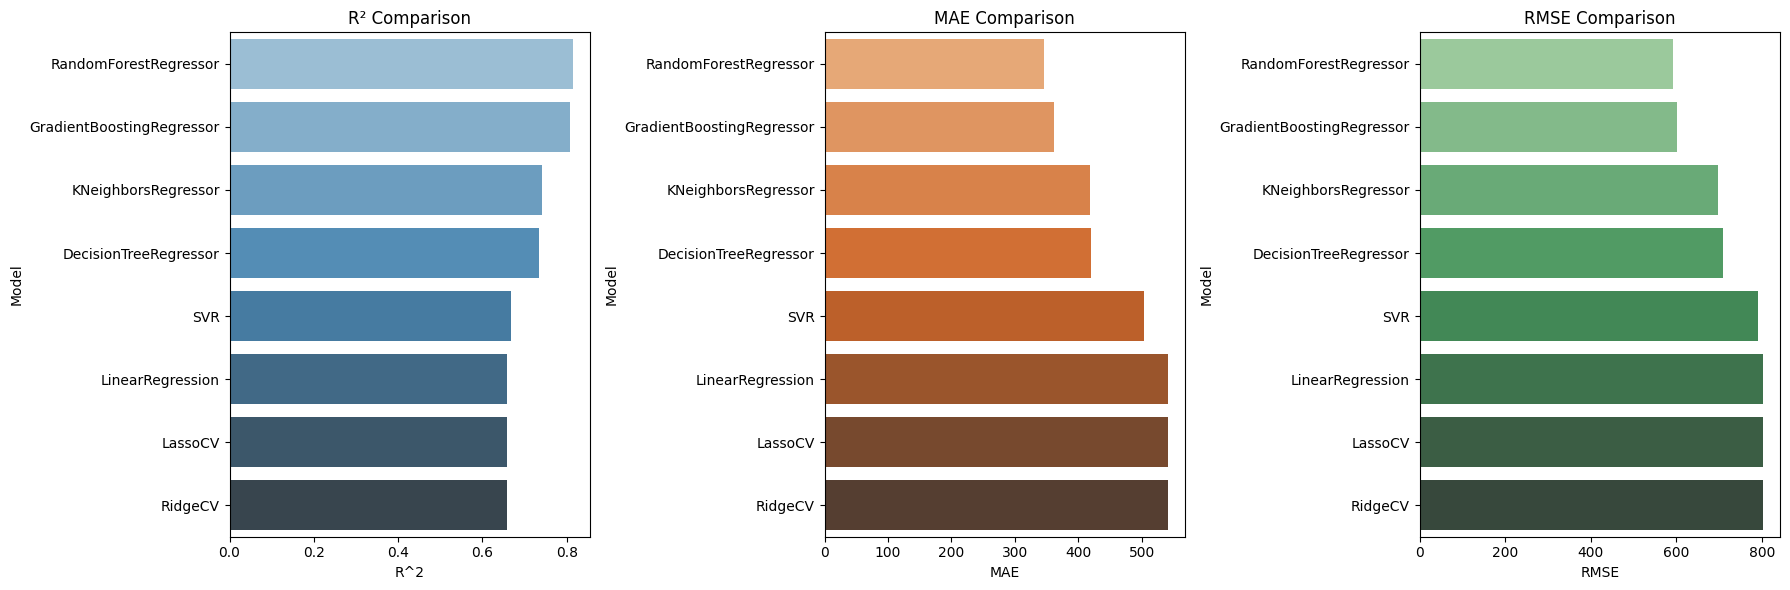

In [177]:
# Створюємо візуалізацію порівняння моделей
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Порівняння R^2
sns.barplot(x='R^2', y='Model', data=results_df, ax=axes[0], palette="Blues_d", hue='Model', legend=False)
axes[0].set_title('R² Comparison')

# Порівняння MAE
sns.barplot(x='MAE', y='Model', data=results_df, ax=axes[1], palette="Oranges_d", hue='Model', legend=False)
axes[1].set_title('MAE Comparison')

# Порівняння RMSE
sns.barplot(x='RMSE', y='Model', data=results_df, ax=axes[2], palette="Greens_d", hue='Model', legend=False)
axes[2].set_title('RMSE Comparison')

plt.tight_layout()
plt.show()

###**Крос-валідація (cross_val_score)**
(розбиття дані на кілька частин (фолдів), навчає модель на частині даних і тестує її на іншій частині). Допомагає оцінити продуктивність моделі на різних вибірках, уникнути overfitting і вибрати найкращі параметри перед підбором гіперпараметрів,допомагає оцінити стабільність моделі (як змінюється якість на різних фолдах), дає більш точну оцінку продуктивності.




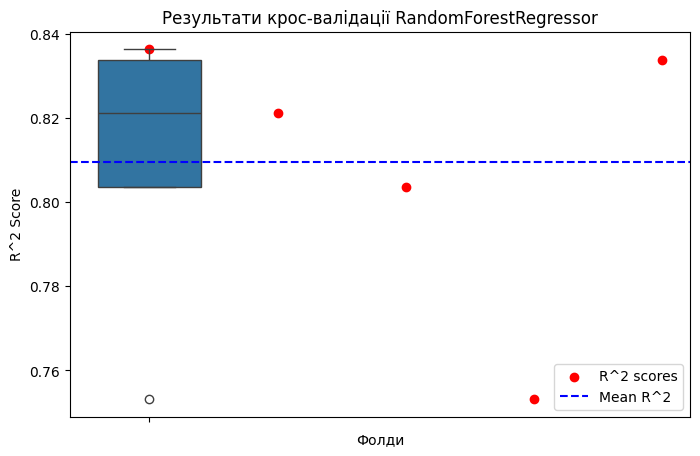

Середній R^2: 0.8096 ± 0.0305


In [138]:
# Обираємо модель
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

# Виконуємо крос-валідацію
cv_scores = cross_val_score(rf_model, X_train, Y_train, cv=5, scoring='r2', n_jobs=-1)


plt.figure(figsize=(8, 5))
sns.boxplot(cv_scores)
plt.scatter(range(len(cv_scores)), cv_scores, color='red', label="R^2 scores")
plt.axhline(y=cv_scores.mean(), color='blue', linestyle='--', label="Mean R^2")
plt.title('Результати крос-валідації RandomForestRegressor')
plt.ylabel('R^2 Score')
plt.xlabel('Фолди')
plt.legend()
plt.show()

# Виведення середнього R^2 та стандартного відхилення
print(f"Середній R^2: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

**Висновок**
-  RandomForestRegressor демонструє високу та стабільну якість прогнозування (R² ≈ 0.81).
- Варіація між фолдами невелика, що свідчить про добру узагальнюваність моделі.
-  Один із фолдів має низьке значення (~0.75), що може вказувати на чутливість до певних підмножин даних.

###Отримаемо важливості ознак у RandomForestRegressor
 атрибутом feature_importances_, який надає оцінку впливу кожної ознаки на модель. Чим вищий значення важливості, тим більший вплив має ознака на прогноз.

In [178]:
# Навчання моделі RandomForest
rf_model.fit(X_train, Y_train)

# Отримання важливості ознак
rf_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_RF': rf_model.feature_importances_
})

# Сортування за важливістю
rf_importance = rf_importance.sort_values(by='Importance_RF', ascending=False)

# Виведення результатів
print(rf_importance)

                 Feature  Importance_RF
1                width_1       0.483947
4  designer_median_price       0.304552
0                depth_1       0.125897
2               height_1       0.053117
3  category_median_price       0.019265
5         other_colors_1       0.013222


**Виснвок** проаналізувавши дані, отримали, що найбільш впливовими колонками для формування цін є:
`width`, `designer`, `depth`

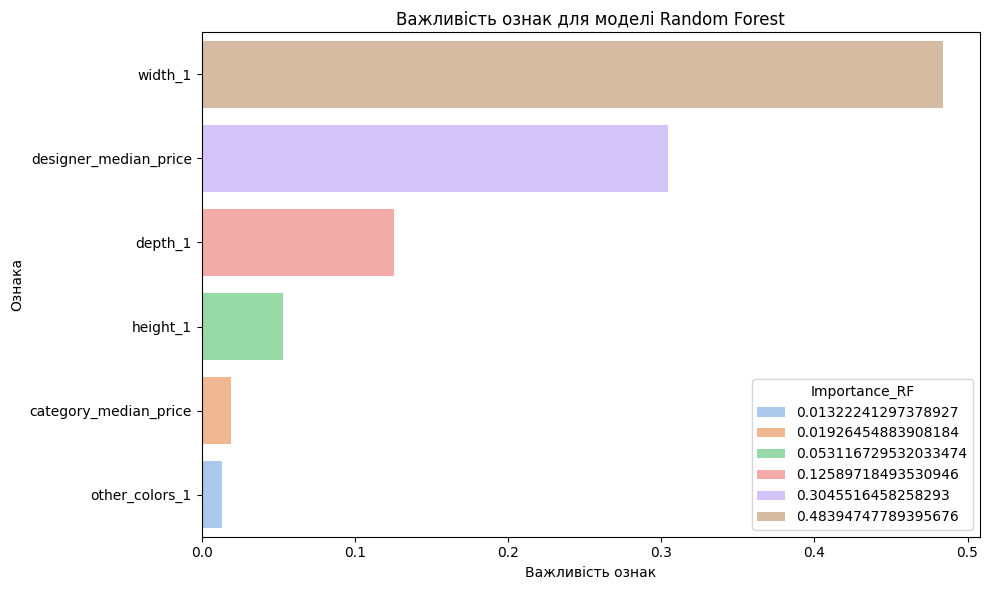

In [179]:
# Створення барплоту для важливості ознак
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance_RF', y='Feature', data=rf_importance, hue='Importance_RF', palette="pastel")
plt.title('Важливість ознак для моделі Random Forest')
plt.xlabel('Важливість ознак')
plt.ylabel('Ознака')
plt.tight_layout()
plt.show()